In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_feature.f')
print(test_.shape)

(8359, 1428)
(8360, 1423)


In [3]:
n_fold = 5

In [4]:
train_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,...,WD_uchi,WD_coast,WD_akai,WD_forge,WD_civil,WD_flash,WD_festa,WD_fest,WD_explore,WD_times,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi
0,LEGO Batman: The Videogame,23,NaN,0,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,425,1,0,8.0,7.0,3.135494,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,49.257785,106.536082,49.231678,59.678899,52.633663,56.848214,289.223684,112.428571,64.319444,81.140351,48.326531,50.646154,56.630137,444.419232,148.275892,72.187084,341.484617,73.847985,96.258706,76.873366,69.018125,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LEGO Indiana Jones: The Original Adventures,23,NaN,0,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,425,1,0,7.0,8.0,3.367296,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,49.148789,66.403374,101.466970,54.090000,48.867470,52.439815,213.160000,54.335079,58.293233,483.589744,89.802260,75.231343,96.758065,462.863031,120.188797,75.206074,174.818593,341.906251,91.001509,72.338596,62.128944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LEGO Batman: The Videogame,17,NaN,0,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,425,1,0,7.0,7.0,2.397895,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,53.568595,64.981846,46.931655,48.185714,53.033898,58.454936,31.886792,58.615789,60.314286,45.701493,47.107692,53.884615,57.709821,69.859005,132.194405,81.714638,150.222097,77.663440,114.136366,82.460642,74.957223,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Combat,0,NaN,0,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,467,6,0,NaN,NaN,NaN,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,NaN,NaN,NaN,52.269231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,149.649097,NaN,NaN,NaN,49.684249,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,23,NaN,0,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,425,1,0,8.0,8.0,2.639057,1320,3370,235,77,1420,2830,2366,96.597250,58.394680,49.148789,99.656627,101.466970,54.090000,48.867470,52.439815,284.891892,96.550173,68.844595,483.589744,89.802260,75.231343,113.766932,462.863031,120.188797,75.206074,329.210611,341.906251,91.001509,72.338596,62.128944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
test_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,TGE_Global_Sales_std_by_User_Score_int_Platform,TGE_Global_Sales_std_by_User_Score_int_Genre,TGE_Global_Sales_std_by_User_Score_int_Rating,TGE_Global_Sales_std_by_Critic_Score_int_Platform,TGE_Global_Sales_std_by_Critic_Score_int_Genre,...,WD_uchi,WD_coast,WD_akai,WD_forge,WD_civil,WD_flash,WD_festa,WD_fest,WD_explore,WD_times,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi
0,Hitman 2: Silent Assassin,26,NaN,0,Eidos Interactive,84.0,23.0,8.0,19.0,216,3,0,8.0,8.0,2.995732,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,34.246377,90.017778,88.489083,111.091346,64.594512,139.218459,203.600983,320.473808,323.717868,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,44.125958,95.640508,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Legacy of Kain: Soul Reaver,13,NaN,0,Eidos Interactive,91.0,17.0,9.0,132.0,112,5,0,9.0,9.0,4.890349,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,51.920228,325.000000,156.375000,104.608491,412.666667,190.612903,164.576923,215.804348,129.886997,139.218459,99.850190,235.111932,327.145440,108.623828,289.354320,96.611679,360.629311,287.232653,191.872644,328.886578,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Metal Gear Solid 2: Substance,26,NaN,0,Konami Digital Entertainment,87.0,28.0,8.5,39.0,469,3,0,8.0,9.0,3.688879,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,57.935484,190.612903,201.981308,201.214689,64.594512,139.218459,203.600983,320.473808,327.145440,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,52.441037,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Silent Hill: Homecoming,25,NaN,0,Konami Digital Entertainment,70.0,54.0,6.9,180.0,134,3,0,7.0,7.0,5.198497,1262,3370,834,22,1563,1634,2019,81.399660,61.011474,96.410622,66.212871,48.703390,82.083333,150.326531,118.701987,73.521368,55.267241,56.746753,63.443299,47.967078,43.502703,60.283688,176.257783,139.218459,203.600983,166.455204,77.728797,169.844360,252.860164,266.693331,129.471179,62.048279,105.468923,82.354034,59.726572,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [6]:
# lgbm_param = {
#     'objective' : 'regression',
#     'boosting_type': 'gbdt',
#     'metric': 'rmse',
#     'seed' : 0,
#     'learning_rate':  0.1,
#     'max_depth': 6,
#     'colsample_bytree': .5,
#     'importance_type': 'gain'
# }
cat_params = {
    'depth' : 6,
    'learning_rate' : 0.1, 
    'early_stopping_rounds' : 10,
    'iterations' : 1000, 
    'eval_metric' :'RMSE', 
    'random_seed' :0
}

In [7]:
categorical_features = ['Platform', 'Genre', 'Developer', 'Rating']

In [8]:
def train_catboost(X, y, group, params: dict, verbose=100):

    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = list(fold.split(X)) 
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
#         lgbm_train = lgbm.Dataset(x_train, y_train)
#         lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
#         lgbm_model = lgbm.train(params, 
#                                                     lgbm_train, 
#                                                     valid_sets=lgbm_eval,
#                                                     num_boost_round=10000,
#                                                     early_stopping_rounds=verbose,
#                                                     verbose_eval=verbose)
#         y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)

        train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, verbose=10, use_best_model=True)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[idx_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [9]:
def train_catboost_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
#         lgbm_train = lgbm.Dataset(x_train, y_train)
#         lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
#         lgbm_model = lgbm.train(params, 
#                                                     lgbm_train, 
#                                                     valid_sets=lgbm_eval,
#                                                     num_boost_round=10000,
#                                                     early_stopping_rounds=verbose,
#                                                     verbose_eval=verbose)
#         y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)

        
        train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, verbose=10, use_best_model=True)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[is_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [10]:
def train_pred(train_df, y, test_df, group):
    oof, models, score = train_catboost_group(train_df, y, group, cat_params)
    
    pred_list = []
    for model in models:
            test_pool = Pool(data=test_df, cat_features=categorical_features)
            pred = model.predict(test_pool)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [11]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [12]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

x_train (6174, 1421)
x_valid (2185, 1421)
0:	learn: 1.2355341	test: 1.6849758	best: 1.6849758 (0)	total: 96ms	remaining: 1m 35s
10:	learn: 1.0137387	test: 1.5604752	best: 1.5604752 (10)	total: 429ms	remaining: 38.5s
20:	learn: 0.9392210	test: 1.4988863	best: 1.4988863 (20)	total: 735ms	remaining: 34.3s
30:	learn: 0.8994975	test: 1.4783632	best: 1.4728697 (26)	total: 1.08s	remaining: 33.9s
40:	learn: 0.8728239	test: 1.4456731	best: 1.4456731 (40)	total: 1.37s	remaining: 32s
50:	learn: 0.8515509	test: 1.4409635	best: 1.4389728 (43)	total: 1.66s	remaining: 31s
60:	learn: 0.8391828	test: 1.4262087	best: 1.4261846 (59)	total: 1.97s	remaining: 30.3s
70:	learn: 0.8285853	test: 1.4215615	best: 1.4186922 (65)	total: 2.29s	remaining: 30s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.418692165
bestIteration = 65

Shrink model to first 66 iterations.
Fold 0 Score: 1.4187
x_train (7540, 1421)
x_valid (819, 1421)
0:	learn: 1.3463167	test: 1.3799608	best: 1.3799608 (0)	total: 38

In [13]:
# feature_importance(models).head(50)

In [14]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 24.61134567582743
max= 362.5454574002914


Text(0.5, 0, 'Global_Sales')

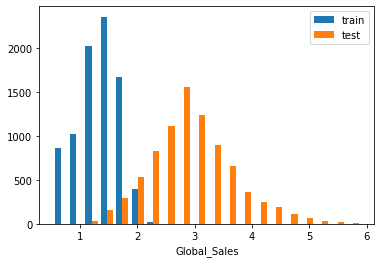

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [16]:
FILENAME = 'submission_cat.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_cat.csv


In [17]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- score = {:.4f}'.format(score))

- feat = 1421
- mean = 24.6113
- max = 362.5455
- score = 1.1017


#### 20cat: catboost
- feat = 1421
- mean = 24.6113
- max = 362.5455
- score = 1.1017
- LB= 0.929

#### 20lgbm
- feat = 1421
- mean = 24.6853
- max = 532.8670
- score = 1.0875

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001　★best★